# INM430 Coursework Final Submission Part-2 - Analysis Files

## Table of Contents
1. [Setup](#setup)
2. [Loading the Data](#loading-the-data)
3. [Data Exploration](#data-exploration)
4. [Baseline Model](#baseline-model)
5. [TF-IDF Representation](#tf-idf-representation)
6. [Doc2Vec Representation](#doc2vec-representation)
7. [Evaluation](#evaluation)

<a name="setup"></a>
## 1. Setup

Hide errors for presentation purposes

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import dependencies

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import multiprocessing
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from pipelinehelper import PipelineHelper
import re
import seaborn as sns
from sklearn import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
# need to choose between GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline

<a name="loading-the-data"></a>
## 2. Loading the Data

Due to some parsing errors with the web scraper, some lyrics were not returned to appear as empty strings or null values in the CSV file.

In [3]:
tracks_by_artist = pd.read_csv("./data/tracks_with_lyrics_for_top_10_artists.csv")
tracks_by_artist = tracks_by_artist[~tracks_by_artist["lyrics"].isnull()]

In [4]:
tracks_by_artist.head()

,artist,album,track,lyrics
0,T.I.,Trap Muzik,I Can't Quit,"[Intro]\nHuh, hell nah, I can't quit\nHell nah..."
1,T.I.,Trap Muzik,Be Easy,"[Intro]\nUh-uh, uh-uh, uh\nAye, where the pian..."
2,T.I.,Trap Muzik,No More Talk,[Verse 1]\nI'm either running for my life or I...
3,T.I.,Trap Muzik,Doin My Job,"[T.I. - talking]\nAy I'm working here, know wh..."
4,T.I.,Trap Muzik,24's,"[Intro]\nYeah\nFor all my real ATL niggas, tha..."


In [5]:
tracks_by_artist.shape

(679, 4)

Have a total of 679 tracks with lyrics with artist name and album title as additional metadata

<a name="data-exploration"></a>
## 3. Data Exploration

The following illustrates the break down of the number of tracks by artist considered in this project. This has implications for the evaluation metrics I will report in the investigation. The following considerations are important to decide the evaluation metrics,

* The project deals with a supervised, multiclass classification task,
* The classes in the original dataset are unbalanced.

For these reasons, I will report the precision, recall, and fscore for each model.

Text(0.5,1,'Total Number of Tracks with Lyrics by Artist')

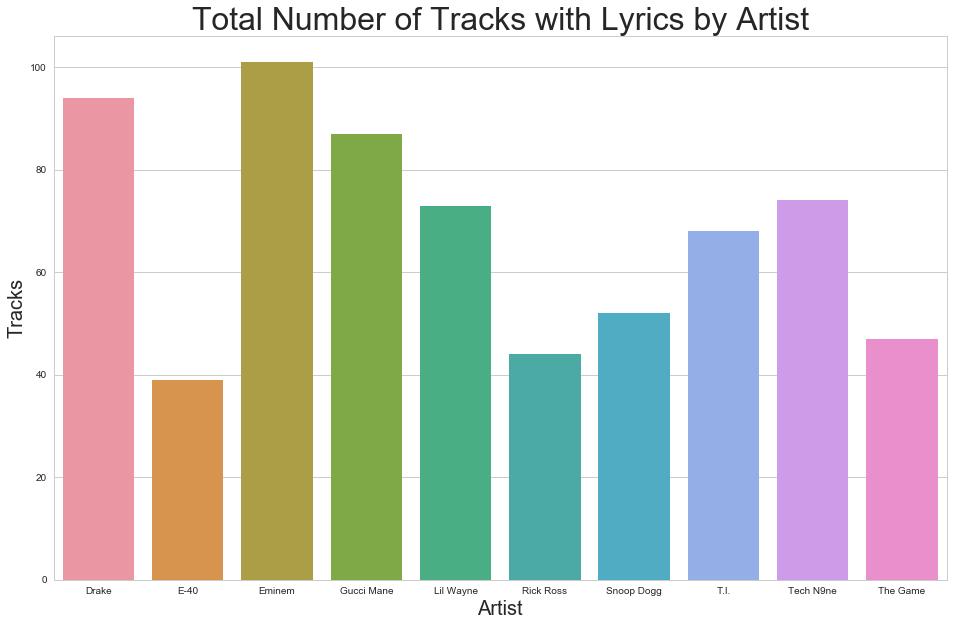

In [6]:
total_tracks_by_artist = tracks_by_artist.groupby("artist").agg("count")[["track"]]
total_tracks_by_artist = total_tracks_by_artist.reset_index()
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(ax=ax, x="artist", y="track", data=total_tracks_by_artist)
ax.set_xlabel("Artist", fontsize=20)
ax.set_ylabel("Tracks", fontsize=20)
ax.set_title("Total Number of Tracks with Lyrics by Artist", fontsize=32)

Same as above but with numbers

In [7]:
tracks_by_artist.groupby("artist")["track"].agg("count")

artist
Drake          94
E-40           39
Eminem        101
Gucci Mane     87
Lil Wayne      73
Rick Ross      44
Snoop Dogg     52
T.I.           68
Tech N9ne      74
The Game       47
Name: track, dtype: int64

<a name="baseline-model"></a>
## 4. Baseline Model

For a like to like comparison with future text representations and models, this section reports on the testing results of a logistic regression classifier using a Bag-of-Words representation. This is very basic but will help indicate whether choices for later models help to improve on the overall classification task.

In [8]:
X = tracks_by_artist[['lyrics']].as_matrix()
y = tracks_by_artist[['artist']].as_matrix()

# Default number of split is 10
stratified_split = StratifiedShuffleSplit(test_size=0.3, random_state=34)
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
# Try and move this into pipeline

bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train.ravel())
X_test_bow = bow.transform(X_test.ravel())

Perform grid search cross-validation to find the optimal value for the C parameter. The predictions are generated from the model with this value for C.

In [10]:
param_grid = {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}

logreg = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid)
logreg.fit(X_train_bow, y_train.ravel())
y_pred = logreg.predict(X_test_bow)

prfs = precision_recall_fscore_support(y_test.ravel(), y_pred, average='weighted', labels=np.unique(y_pred))

Reported results for baseline model.

In [11]:
print('Testing Precision: {}'.format(prfs[0]))
print('Testing Recall: {}'.format(prfs[1]))
print('Testing FScore: {}'.format(prfs[2]))
print("Logistic Regression Param C: {}".format(logreg.best_params_["C"]))

Testing Precision: 0.74245137781322
Testing Recall: 0.7303921568627451
Testing FScore: 0.7303365599858972
Logistic Regression Param C: 0.1


<a name="tf-idf-representation"></a>
## 5. TF-IDF Representation

Models to be considered,

* Logistic Regression 
* Linear SVM
* Naive Bayes

In [21]:
# Helper functions

def best_results_by_model(grid_scores):
    
    best_results_by_model = {}
    for score in grid_scores:
        model_name = score[0]["classifier__selected_model"][0]
        if (model_name not in best_results_by_model) or (score[1] > best_results_by_model[model_name]["mean"]):
            best_results_by_model[model_name] = {
                "params": score[0],
                "mean": score[1],
                "results": score[2],
            }
    
    return best_results_by_model   

### Feature engineering

The features I will be considering in this project are,

* Encoded track lyrics: I will con. This will be the main variable in the project
* Track line count: the total number of lines in each track, breaking on newline characters "\n"
* Average line length: the number of words 
* Unique word proportion: the proportion of unique words out of the total number of words in a given track
* ...

These are all generated from the raw lyrics from the data collection process

### TF-IDF 

In [12]:
# Custom Transformers

class LyricsExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].values
    
class VectorExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["vectors"].values

class LineCountExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(len)

class AverageLineLengthExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(lambda lines: sum(map(len,lines))/len(lines))

class UniqueWordProportionExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: self.__prop_unique_words(lyrics))
    
    def __prop_unique_words(self, lyrics):
        return self.__get_unique_word_count(lyrics) / self.__get_total_word_count(lyrics)
    
    def __get_total_word_count(self, lyrics):
        return len(re.split(" |\n|", lyrics))
    
    def __get_unique_word_count(self, lyrics):
        return len(set(re.split(" |\n|", lyrics)))

class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.transpose(np.matrix(data))

In [13]:
# Pipelines

# song_vectors = Pipeline([
#             ("lyrics", LyricsExtractor()),
#             ("tfidf", TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=word_tokenize))
#         ])

song_vectors = Pipeline([
                ("vector", VectorExtractor())
            ])

line_count = Pipeline([
                ("get_line_count", LineCountExtractor()),
                ("caster", ArrayCaster())
            ])

average_line_length = Pipeline([
                ("get_average_line_length", AverageLineLengthExtractor()),
                ("caster", ArrayCaster())
            ])

unique_word_proportion = Pipeline([
                ("get_unique_word_proportion", UniqueWordProportionExtractor()),
                ("caster", ArrayCaster())
            ])

# other features go here ...

In [14]:
tfidf_featureunion = FeatureUnion([
    ("line_count", line_count),
    ("song_vectors", song_vectors),
    ("average_line_length", average_line_length),
    ("unique_word_proportion", unique_word_proportion)
])

In [45]:
# may or may not require dense matrix representation for classifiers
# at least for GaussianNB classifier
# see https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
# for details

In [51]:
tfidf_pipeline = Pipeline([
    ("featureunion", featureunion),
    ("classifier", PipelineHelper([
        ("MultinomialNB", MultinomialNB()),
        ("LogisticRegression", LogisticRegression()),
        ("LinearSVC", LinearSVC())
    ]))
])

In [160]:
param_grid = {
#     "tfidf_featureunion__song_vect__tfidf__max_df": [0.7, 0.8, 1.0],
#     "tfidf_featureunion__song_vect__tfidf__min_df": [1, 5, 20],
    "tfidf_featureunion__transformer_weights": [
        # one feature only
        {"song_vectors":0,"line_count":0, "average_line_length":0, "unique_word_proportion":1},#0001
#         {"song_vectors":0,"line_count":0, "average_line_length":1, "unique_word_proportion":0},#0010
#         {"song_vectors":0,"line_count":1, "average_line_length":0, "unique_word_proportion":0},#0100
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":0},#1000
        
        # two features
#         {"song_vectors":0,"line_count":0, "average_line_length":1, "unique_word_proportion":1},#0011
#         {"song_vectors":0,"line_count":1, "average_line_length":0, "unique_word_proportion":1},#0101
#         {"song_vectors":0,"line_count":1, "average_line_length":1, "unique_word_proportion":0},#0110
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":1},#1001
#         {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":0},#1010
#         {"song_vectors":1,"line_count":1, "average_line_length":0, "unique_word_proportion":0},#1100
        
        # three features
#         {"song_vectors":0,"line_count":1, "average_line_length":1, "unique_word_proportion":1},#0111
#         {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1},#1011
#         {"song_vectors":1,"line_count":1, "average_line_length":0, "unique_word_proportion":1},#1101
#         {"song_vectors":1,"line_count":1, "average_line_length":1, "unique_word_proportion":0},#1110
        
        # all features
#         {"song_vectors":1,"line_count":1, "average_line_length": 1, "unique_word_proportion": 1},#1111
    ],
    # need to put range of classifiers here
    "classifier__selected_model": tfidf_pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e5, 1e6, 1e7]
    })
}

In [53]:
# can also indicate scoring metric
gs_clf = GridSearchCV(tfidf_pipeline, param_grid, cv=5)

In [144]:
# for hp in hyperparamters:

vectorizer = TfidfVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    max_df=0.7,
    min_df=5,
    tokenizer=word_tokenize,
)

tracks_by_artist["vectors"] = list(vectorizer.fit_transform(tracks_by_artist["lyrics"].values).toarray())
# tracks_by_artist = tracks_by_artist[tracks_by_artist["unnormalised_vectors"].apply(sum) != 0]

In [145]:
# Want to use train, test data from StratifiedShuffleSplit above
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [146]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf_featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('line_count', Pipeline(memory=None,
     steps=[('get_line_count', LineCountExtractor()), ('caster', ArrayCaster())])), ('song_vect', Pipeline(memory=None,
     steps=[('lyrics', LyricsExtractor()), ('tfidf', TfidfVectori...andom_state=None, tol=0.0001,
     verbose=0)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfidf_featureunion__song_vect__tfidf__max_df': [0.7, 0.8, 1.0], 'tfidf_featureunion__song_vect__tfidf__min_df': [1, 5, 20], 'tfidf_featureunion__transformer_weights': [{'song_vectors': 0, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 1}, {'song_vectors': 1, 'line_...: 1000000.0}), ('LogisticRegression', {'C': 10000000.0}), ('MultinomialNB', {}), ('LinearSVC', {})]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [147]:
# This are only the scores reported on training set - 
# so need to run best model against test set as well
best_results_by_model(gs_clf.grid_scores_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'LinearSVC': {'mean': 0.8147368421052632,
  'params': {'classifier__selected_model': ('LinearSVC', {}),
   'tfidf_featureunion__song_vect__tfidf__max_df': 0.8,
   'tfidf_featureunion__song_vect__tfidf__min_df': 5,
   'tfidf_featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_vectors': 0,
    'unique_word_proportion': 1}},
  'results': array([0.80808081, 0.81818182, 0.83157895, 0.83870968, 0.7752809 ])},
 'LogisticRegression': {'mean': 0.8105263157894737,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 100000.0}),
   'tfidf_featureunion__song_vect__tfidf__max_df': 0.8,
   'tfidf_featureunion__song_vect__tfidf__min_df': 1,
   'tfidf_featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.80808081, 0.82828283, 0.84210526, 0.80645161, 0.76404494])},
 'MultinomialNB': {'mean': 0.6526315789473685,
  'params': {'clas

In [149]:
y_pred = gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.8490808185643727
Testing Recall: 0.8480392156862745
Testing FScore: 0.8425592978189723


<a name="doc2vec-representation"></a>
## 6. Doc2Vec Representation

In [5]:
# data_x = tracks_by_artist[['lyrics']].as_matrix()
# data_y = tracks_by_artist[['artist']].as_matrix()
# stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=34)
# for train_index, test_index in stratified_split.split(data_x, data_y):
#     x_train, x_test = data_x[train_index], data_x[test_index]
#     y_train, y_test = data_y[train_index], data_y[test_index]

# X_train = [x[0] for x in x_train.tolist()]
# X_test = [x[0] for x in x_test.tolist()]

# Want to use train, test data from StratifiedShuffleSplit above
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34)
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [181]:
# data_x = tracks_by_artist[['lyrics']].as_matrix()
# data_y = tracks_by_artist[['artist']].as_matrix()
# stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=34)
# for train_index, test_index in stratified_split.split(data_x, data_y):
#     x_train, x_test = data_x[train_index], data_x[test_index]
#     y_train, y_test = data_y[train_index], data_y[test_index]

In [6]:
train_tagged = [TaggedDocument(words=word_tokenize(X_train["lyrics"].tolist()[idx]), tags=y_train.tolist()[idx]) for idx, _ in enumerate(y_train)]
test_tagged = [TaggedDocument(words=word_tokenize(X_test["lyrics"].tolist()[idx]), tags=y_test.tolist()[idx]) for idx, _ in enumerate(y_test)]

In [7]:
model_dbow = Doc2Vec(dm=0, vector_size=300, sample=0, workers=multiprocessing.cpu_count())
model_dbow.build_vocab(train_tagged)

In [8]:
# check if this is correct
# def model_dbow():
#     model_dbow = Doc2Vec(dm=0, vector_size=300, sample=0, workers=multiprocessing.cpu_count())
#     model_dbow.build_vocab(train_tagged)

max_epochs = 30
for epoch in range(max_epochs):
    model_dbow.train(utils.shuffle(train_tagged), total_examples=model_dbow.corpus_count, epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [9]:
def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

In [10]:
y_train, X_train["vectors"] = vec_for_learning(model_dbow, train_tagged)
y_test, X_test["vectors"] = vec_for_learning(model_dbow, test_tagged)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
X_train.head()

,artist,album,track,lyrics,vectors
319,The Game,Doctor's Advocate,Lookin at You,[Hook: sung by Tracey Nelson]\nWalking down th...,"[0.53838754, -0.101766944, -0.8675869, 0.24905..."
259,Lil Wayne,Tha Carter II,On Tha Block #2 (Skit),Female: Wassup shorty you still hangin' 'round...,"[-0.569331, -0.04034642, -0.43255407, 0.190325..."
148,Eminem,The Marshall Mathers LP 2,So Much Better,[Intro]\nYou fuckin' groupie!\nPick up the god...,"[0.27775523, -0.59056073, -1.5388396, 0.606342..."
20,T.I.,Urban Legend,Bring Em Out,"[Intro: Jay Z snippet]\n(Bring 'em out, Its ha...","[0.52688396, -0.8119597, -0.8052492, 0.0237792..."
185,Snoop Dogg,R&G (Rhythm & Gangsta): The Masterpiece,Bang Out,"[Hook: Jasmin Lopez]\nBang out, til the sun co...","[-0.56564164, -0.39776784, -0.6098711, 0.35768..."


In [63]:
class VectorExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["vectors"]

class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

song_vectors = Pipeline([
                ("vector", VectorExtractor()),
                ("tolist", ListCaster()),
            ])

In [64]:
doc2vec_featureunion = FeatureUnion([
#     ("line_count", line_count),
    ("song_vectors", song_vectors),
#     ("average_line_length", average_line_length),
#     ("unique_word_proportion", unique_word_proportion)
])

In [65]:
doc2vec_pipeline = Pipeline([
    ("doc2vec_featureunion", doc2vec_featureunion),
    ("classifier", PipelineHelper([
        ("LogisticRegression", LogisticRegression())
    ]))
])

In [66]:
param_grid = {
    # need to put range of classifiers here
    "classifier__selected_model": doc2vec_pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e5, 1e6, 1e7]
    })
}

In [67]:
doc2vec_gs_clf = GridSearchCV(doc2vec_pipeline, param_grid, cv=5)

In [68]:
doc2vec_gs_clf.fit(X_train, list(y_train))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('doc2vec_featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('song_vectors', Pipeline(memory=None,
     steps=[('vector', VectorExtractor()), ('tolist', ListCaster())]))],
       transformer_weights=None)), ('classifier', PipelineHelper(available_models={'LogisticRegression': Log....0001,
          verbose=0, warm_start=False)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__selected_model': [('LogisticRegression', {'C': 100000.0}), ('LogisticRegression', {'C': 1000000.0}), ('LogisticRegression', {'C': 10000000.0})]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
best_results_by_model(doc2vec_gs_clf.grid_scores_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'LogisticRegression': {'mean': 0.8673684210526316,
  'params': {'classifier__selected_model': ('LogisticRegression',
    {'C': 100000.0})},
  'results': array([0.88888889, 0.8556701 , 0.88297872, 0.80645161, 0.90217391])}}

In [ ]:
# tfidf_featureunion = FeatureUnion([
#     ("line_count", line_count),
#     ("song_vectors", song_vectors),
#     ("average_line_length", average_line_length),
#     ("unique_word_proportion", unique_word_proportion)
# ])

# tfidf_pipeline = Pipeline([
#     ("featureunion", featureunion),
#     ("classifier", PipelineHelper([
#         ("MultinomialNB", MultinomialNB()),
#         ("LogisticRegression", LogisticRegression()),
#         ("LinearSVC", LinearSVC())
#     ]))
# ])

# TODO
# * Doc2Vec with DMM
# * Doc2Vec with combined DBOW and DMM models
# * Classifiers, LogisticRegression, LinearSVM, Multinomial NB

In [62]:
logreg = LogisticRegression()
logreg.fit(X_train["vectors"].tolist(), list(y_train))
y_pred = logreg.predict(X_test["vectors"].tolist())

prfs = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Testing Precision: {}'.format(prfs[0]))
print('Testing Recall: {}'.format(prfs[1]))
print('Testing FScore: {}'.format(prfs[2]))

Testing Precision: 0.7812956243103301
Testing Recall: 0.7647058823529411
Testing FScore: 0.7601682069248044


<a name="evaluation"></a>
## 7. Evaluation

In [59]:
X_train["vectors"].tolist()

[array([ 5.38387537e-01, -1.01766944e-01, -8.67586911e-01,  2.49059454e-01,
        -2.74612129e-01,  3.93516779e-01,  1.34452775e-01,  2.27076896e-02,
         3.01752627e-01, -1.20263115e-01, -1.13401793e-01,  1.43397972e-01,
        -2.04836577e-01,  2.45756321e-02,  2.38517493e-01, -1.81545481e-01,
        -6.29360676e-02, -8.16598535e-02, -6.89721107e-01,  5.64423110e-03,
         1.59369081e-01,  2.51692355e-01, -2.46926531e-01, -4.39670801e-01,
        -2.11148649e-01,  3.65354389e-01, -1.46019503e-01, -1.45140905e-02,
         9.93013024e-01, -7.40912044e-03, -5.40175974e-01,  1.61503330e-01,
        -1.29616588e-01, -3.45446825e-01, -1.29962146e-01, -2.16804398e-03,
        -3.11463118e-01, -1.60864621e-01,  1.41532913e-01, -1.08061954e-01,
        -3.85812074e-01, -2.77945578e-01, -4.16618958e-03, -5.48204556e-02,
         1.87656909e-01, -8.21258314e-03,  6.08464591e-02,  2.19768770e-02,
         1.96894899e-01, -2.07338601e-01, -3.55552614e-01, -8.62696394e-02,
         5.0